In [57]:
import numpy as np
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [36]:
def normalize_eigenvectors(e):
    """
    Normalizes an eigenvector
    """
    return e/np.sqrt(np.sum(e**2))

In [48]:
def laplacian(G, laplacian_type="unnormalized"):
    """
    Create the Laplacian from a graph

    Parameters
    ----------
    G: nx.graph
        The graph for which to construct the Laplacian for
    laplacian_type: Type of laplacian
        "unnormalized": L = D - W
        "symmetric": L = I - D^{-1/2}*W*D^{-1/2}
        "random_walk": I - D^(-1)*W

    Returns
    -------
    L: np.array
        The laplacian of G
    """

    D = np.diag(np.sum(np.array(nx.adjacency_matrix(G).todense()), axis=1))
    W = nx.adjacency_matrix(G).toarray()

    assert D.shape == W.shape, "Shapes of D and W don't match."

    L = None

    if laplacian_type == "unnormalized":
        L = D - W
    elif laplacian_type == "symmetric":
        I = np.ones(D.shape)
        D_inv_root = np.linalg.inv(np.sqrt(D))

        L = I - np.dot(D_inv_root, W).dot(D_inv_root)
    elif laplacian_type == "random_walk":
        I = np.ones(D.shape)
        D_inv = np.linalg.matrix_power(D, -1)

        L = I - np.matmul(D_inv, W)
    else:
        raise ValueError("Laplacian type can be 'normalized' or 'unnormalized'.")

    return L

In [3]:
def generate_labels_dict(G, kmeans):
    """
    Creates a dictionary with keys as cluster numbers and values
    as nodes in G.
    E.g. {0: [1, 2], 1: [0], 3: [3, 4, 5]}

    Parameters
    ----------
    G: nx.Graph
        Graph with the nodes in question
    kmeans: sklearn.cluster.KMeans
        A KMeans object which has already been fit on the data

    Returns
    -------
    labels_dict: Dict[int, List[int]]
        Mapping between cluster number and nodes
    """

    num_nodes = len(G.nodes)
    num_clusters = kmeans.n_clusters

    labels_dict = {c: [] for c in range(num_clusters)}
    
    for i in range(num_nodes):
        labels_dict[kmeans.labels_[i]].append(i)

    return labels_dict

In [83]:
def visualize_graph(G, pos, labels_dict=None, colors=None, node_size=100, edge_alpha=0.1, labels=False):
    """
    Visualizes graph with clusters as different colors
    """

    if labels_dict is not None and colors is not None:
        for k, v in labels_dict.items():
            # nodes
            nx.draw_networkx_nodes(G, 
                pos,
                nodelist=v,
                node_color=colors[k],
                node_size=node_size
            )
    else:
        nx.draw_networkx_nodes(G, pos, node_size=node_size) 
        
    if labels:
        nx.draw_networkx_labels(G, pos)

    nx.draw_networkx_edges(G, pos, width=1.0, alpha=edge_alpha)

In [87]:
def spectral_clustering(G, k, pos, colors, visualize=True, laplacian_type="unnormalized", **kwargs):
    """
    Implement spectral clustering
    """
    # Calculate Laplacian
    L = laplacian(G, laplacian_type=laplacian_type)

    # Get eigenvectors from the Laplacian
    _, eig_vectors = sp.linalg.eigs(L, k)
    
    # Use eigenvectors as features
    U = eig_vectors.real
    
    if laplacian_type == "symmetric":
        U = np.apply_along_axis(normalize_eigenvectors, 0, U)

    # Cluster using KMeans
    kmeans = KMeans(n_clusters=k, random_state=0).fit(U)

    # Get labels
    labels_dict = generate_labels_dict(G, kmeans)

    # Visualize
    if visualize:
        node_size = kwargs.get('node_size', 100)
        edge_alpha = kwargs.get('edge_alpha', 0.1)
        labels = kwargs.get('labels', False)
        
        visualize_graph(G, pos, labels_dict, COLORS, node_size=node_size, edge_alpha=edge_alpha, labels=labels)

    return labels_dict

In [69]:
COLORS = \
    ["tab:blue", "tab:orange", "tab:green", 
     "tab:red", "tab:purple", "tab:brown", 
     "tab:pink", "tab:gray", "tab:olive", 
     "tab:cyan"]

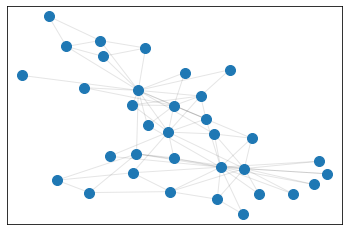

In [96]:
G_kk = nx.karate_club_graph()
pos_kk = nx.spring_layout(G_kk)

visualize_graph(G_kk, pos_kk)

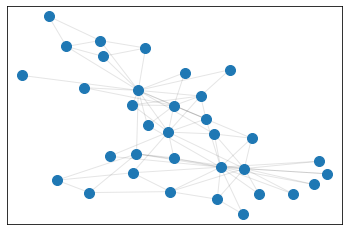

In [98]:
visualize_graph(G_kk, pos_kk)

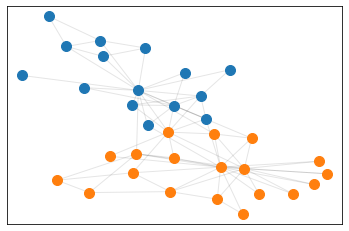

In [100]:
labels_dict = spectral_clustering(G_kk, 2, pos_kk, COLORS, laplacian_type="symmetric")

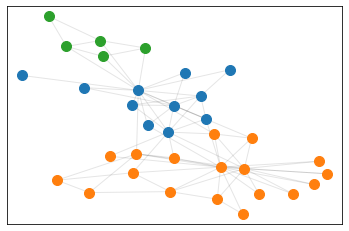

In [101]:
labels_dict = spectral_clustering(G_kk, 3, pos_kk, COLORS, laplacian_type="symmetric")

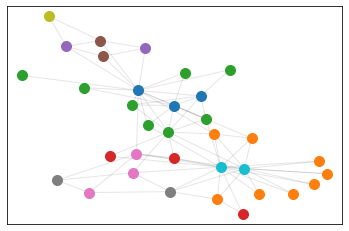

In [102]:
labels_dict = spectral_clustering(G_kk, 10, pos_kk, COLORS, laplacian_type="symmetric")

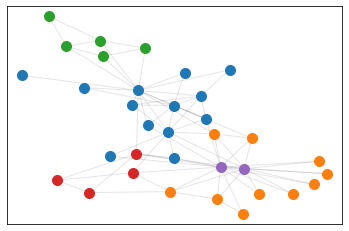

In [97]:
labels_dict = spectral_clustering(G_kk, k, pos_kk, COLORS, laplacian_type="symmetric")

### Testing on Planted L-Partition Model

In [93]:
K = 5
NODES_PER_BUCKET = 200
P_IN = 0.8
P_OUT = 0.1

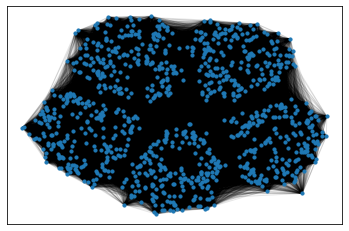

In [94]:
G_pl = nx.generators.community.planted_partition_graph(K, NODES_PER_BUCKET, P_IN, P_OUT)
pos_pl = nx.spring_layout(G_pl)

visualize_graph(G_pl, pos_pl, edge_alpha=0.1, node_size=10, labels=False)

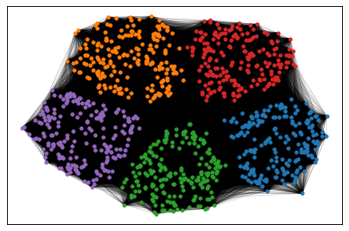

In [95]:
labels_dict = spectral_clustering(G_pl, 
                                  K, 
                                  pos_pl, 
                                  COLORS, 
                                  laplacian_type="symmetric", 
                                  edge_alpha=0.1, 
                                  node_size=10, 
                                  labels=False)

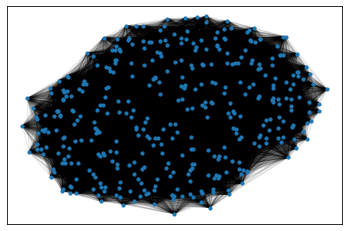

In [106]:
K = 2
NODES_PER_BUCKET = 200
P_IN = 0.6
P_OUT = 0.3

G_ = nx.generators.community.planted_partition_graph(K, NODES_PER_BUCKET, P_IN, P_OUT)
pos_ = nx.spring_layout(G_)

visualize_graph(G_, pos_, edge_alpha=0.1, node_size=10, labels=False)

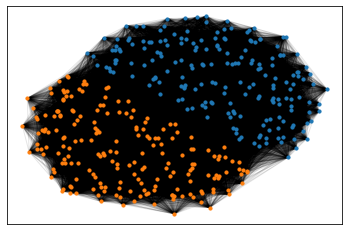

In [107]:
labels_dict = spectral_clustering(G_, 
                                  K, 
                                  pos_, 
                                  COLORS, 
                                  laplacian_type="symmetric", 
                                  edge_alpha=0.1, 
                                  node_size=10, 
                                  labels=False)